In [2]:
# ============================
# Cell 1 — Imports + Custom Env (Continuous CartPole Swing-Up) + EDGE RESPAWN
# + TensorFlow GPU setup (for GPflow/TF compute)
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding

# ---- numpy bool8 compat ----
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# ============================================================
# TensorFlow GPU setup (THIS is what makes TF/GPflow use GPU)
# ============================================================
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter TF logs (optional)

import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Prevent TF from grabbing all VRAM at startup
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ TF version:", tf.__version__)
    print("✅ Built with CUDA:", tf.test.is_built_with_cuda())
    print("✅ GPUs:", gpus)
else:
    print("⚠️ TF version:", tf.__version__)
    print("⚠️ Built with CUDA:", tf.test.is_built_with_cuda())
    print("⚠️ GPUs: [] (TensorFlow will run on CPU)")

# ============================================================
# Dtypes for GPU-friendly pipeline
# ============================================================
# Env can stay float32; GP features should also be float32 to avoid slow casts.
DTYPE_NP = np.float32

# ============================================================
# Angle helpers
# ============================================================
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot
U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_NP):
    """
    GP features (D=6), bounded:
        [ tanh(x/x_scale),
          tanh(xdot/v_scale),
          sin(theta),
          cos(theta),
          tanh(thetadot/w_scale),
          u ]
    Returns float32 by default (GPU-friendly).
    """
    x_feat = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat = np.tanh(thetadot / w_scale)
    return np.array(
        [x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)],
        dtype=dtype
    )

# ============================================================
# Custom Continuous CartPole Swing-Up Env (CPU physics; that's OK)
# ============================================================
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

# ============================================================
# Edge respawn wrapper
# ============================================================
class EdgeRespawnWrapper(gym.Wrapper):
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True
            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs, _ = self.env.reset(seed=seed)

            terminated = False
            truncated = False

        return obs, float(reward), bool(terminated), bool(truncated), info

# ============================================================
# Environment factory
# ============================================================
MAX_EPISODE_STEPS = 600

def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=MAX_EPISODE_STEPS,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ============================================================
# Sanity check
# ============================================================
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)
s = obs_to_state(obs)

print("✅ Env ready (edge_respawn=True)")
print("obs:", obs)
print("state:", s)
print("action space:", env.action_space)
env.close()


✅ TF version: 2.22.0-dev20260209
✅ Built with CUDA: True
✅ GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Env ready (edge_respawn=True)
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
state: (0.013696168549358845, -0.023021329194307327, 3.044898271560669, -0.04590264707803726)
action space: Box(-1.0, 1.0, (1,), float32)


/tmp/ipykernel_179915/2949150058.py:18: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, "bool8"):


In [3]:
import nbformat, IPython
print("nbformat:", nbformat.__version__)
print("ipython:", IPython.__version__)

nbformat: 5.10.4
ipython: 9.10.0


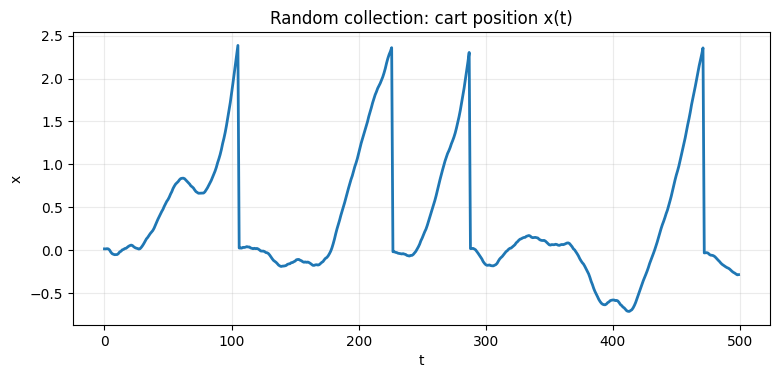

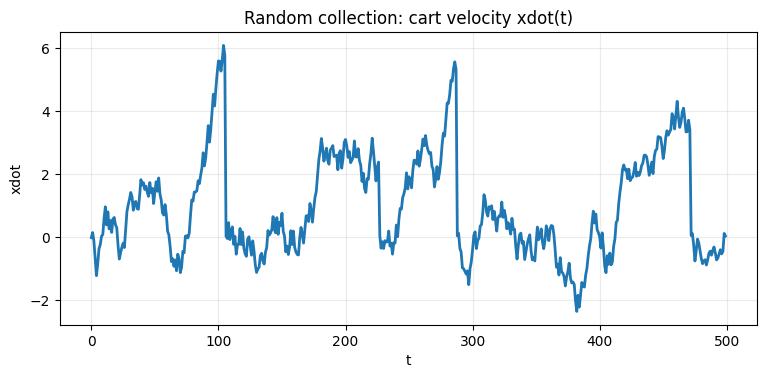

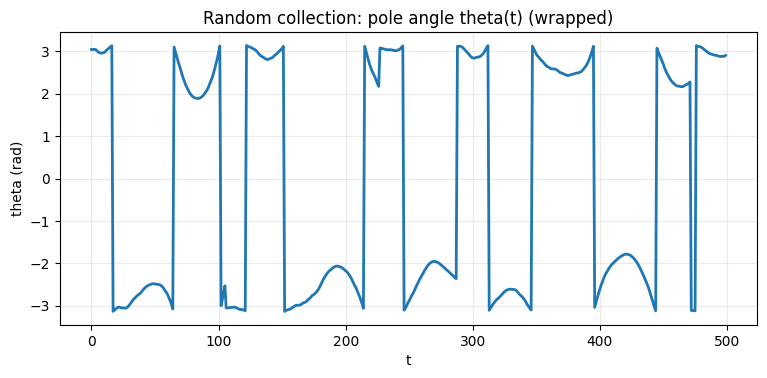

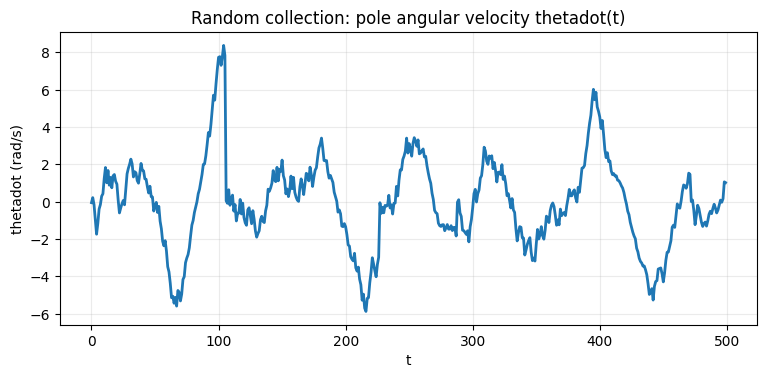

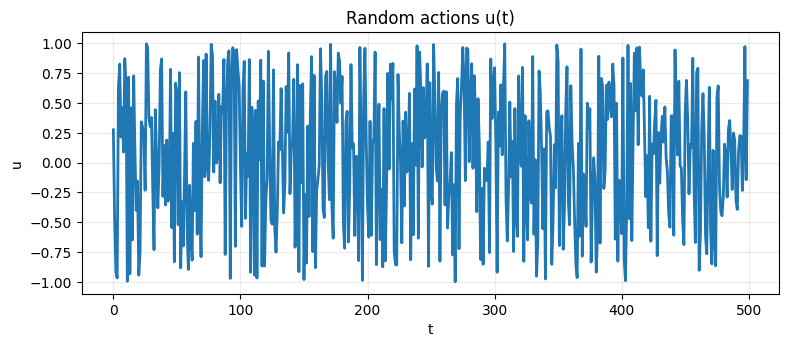

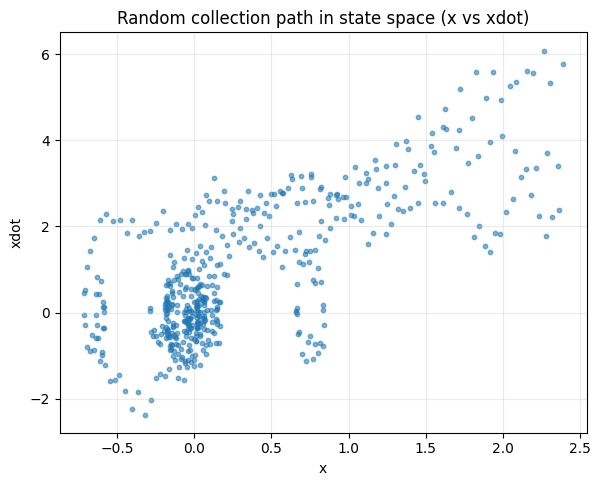

Collected X0 shape: (496, 6)  (6D features)
Targets shapes: (496, 1) (496, 1) (496, 1) (496, 1)
Kept=496  Dropped(respawn)=4  Resets=0


In [4]:

# ============================
# Cell 2 — Render the RANDOM collection path (and collect X,Y)  ✅ CartPole version
#
# Fix:
#   ✅ Adds render_cartpole_frame_from_state() (pure PIL) so the line:
#        frame = render_cartpole_frame_from_state(...)
#      actually works.
#
# What you get:
#   - Runs random actions for n_steps (with resets as needed)
#   - Collects executed transitions:
#       X0: (N,6)  = [x_feat, xdot_feat, sinθ, cosθ, w_feat, u]
#       Ydx0, Ydxdot0, Ydth0, Ydthdot0  (each (N,1))
#   - Records frames (rgb) and displays an inline animation (JS HTML)
#   - Plots trajectories:
#       x(t), xdot(t), theta(t), thetadot(t), action(t)
#       phase plot: x vs xdot
#
# IMPORTANT:
#   - We DO NOT rely on env.render() / pygame.
#   - We render from state using a self-contained PIL renderer below.
#   - If your env does edge respawn and sets info["respawned"]=True, we DROP that transition.
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

from PIL import Image, ImageDraw

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=160,
    pole_width=10,
):
    """
    Minimal CartPole render (rgb uint8) from state.
    Coordinates:
      - x in [-x_threshold, x_threshold] maps to screen track
      - theta: 0 = upright, pi = down (standard)
    """
    # background
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)

    # track line
    y_track = int(0.72 * H)
    dr.line([(0, y_track), (W, y_track)], fill=(210, 210, 210), width=4)

    # map x -> screen px
    # keep margins so cart stays visible
    margin = 40
    x_clamped = float(np.clip(x, -x_threshold, x_threshold))
    x_norm = (x_clamped + x_threshold) / (2 * x_threshold)  # [0,1]
    cx = int(margin + x_norm * (W - 2 * margin))
    cy = y_track - cart_height // 2

    # cart rectangle
    x0 = cx - cart_width // 2
    y0 = cy - cart_height // 2
    x1 = cx + cart_width // 2
    y1 = cy + cart_height // 2
    dr.rounded_rectangle([x0, y0, x1, y1], radius=8, fill=(60, 90, 160), outline=(30, 30, 30), width=2)

    # axle point on top of cart
    ax = cx
    ay = y0 + 6

    # pole end point
    # IMPORTANT: theta=0 is upright -> pole points UP, so use -cos/sin appropriately
    # Standard cartpole uses theta from vertical; here we draw:
    #   dx =  L * sin(theta)
    #   dy = -L * cos(theta)
    dx = pole_length_px * float(np.sin(theta))
    dy = -pole_length_px * float(np.cos(theta))
    px = ax + dx
    py = ay + dy

    # pole (as thick line)
    dr.line([(ax, ay), (px, py)], fill=(180, 50, 50), width=pole_width)

    # axle circle
    r = 8
    dr.ellipse([ax - r, ay - r, ax + r, ay + r], fill=(30, 30, 30))

    return np.asarray(img, dtype=np.uint8)


# ------------------------------------------------------------
# Random collection (rendered)
# ------------------------------------------------------------
def collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=0,
    max_episode_steps=500,
    start_down=True,
    # rendering controls
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # edge-respawn handling (relies on your Cell 1 env.step() putting info["respawned"]=True)
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=True,
):
    rng = np.random.default_rng(seed)

    env_vis = make_env(
        render_mode=None,   # we render ourselves
        seed=seed,
        max_episode_steps=max_episode_steps,
        start_down=start_down,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, info = env_vis.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    X_list, Ydx_list, Ydxdot_list, Ydth_list, Ydthdot_list = [], [], [], [], []

    traj_x, traj_xdot, traj_th, traj_thdot, traj_u = [], [], [], [], []
    frames = []
    dropped = 0
    resets = 0

    for t in range(n_steps):
        u = float(rng.uniform(U_MIN, U_MAX))

        obs2, reward, terminated, truncated, info = env_vis.step(np.array([u], dtype=np.float32))
        x2, xdot2, th2, thdot2 = obs_to_state(obs2)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if respawned and drop_respawn_transitions:
            dropped += 1
        else:
            X_list.append(state_to_features(x, xdot, th, thdot, u))
            Ydx_list.append(x2 - x)
            Ydxdot_list.append(xdot2 - xdot)
            Ydth_list.append(wrap_pi(th2 - th))
            Ydthdot_list.append(thdot2 - thdot)

        traj_x.append(x)
        traj_xdot.append(xdot)
        traj_th.append(th)
        traj_thdot.append(thdot)
        traj_u.append(u)

        if (t % frame_stride) == 0:
            W, H = int(resize[0]), int(resize[1])
            frame = render_cartpole_frame_from_state(x2, th2, x_threshold=2.4, W=W, H=H)
            frames.append(frame)

        x, xdot, th, thdot = x2, xdot2, th2, thdot2

        if terminated or truncated:
            resets += 1
            obs, info = env_vis.reset(seed=int(seed + 123 + t))
            x, xdot, th, thdot = obs_to_state(obs)
            if verbose:
                print(f"[t={t:04d}] reset (terminated={terminated}, truncated={truncated})")

    env_vis.close()

    X0 = np.asarray(X_list, dtype=np.float64)
    Ydx0 = np.asarray(Ydx_list, dtype=np.float64).reshape(-1, 1)
    Ydxdot0 = np.asarray(Ydxdot_list, dtype=np.float64).reshape(-1, 1)
    Ydth0 = np.asarray(Ydth_list, dtype=np.float64).reshape(-1, 1)
    Ydthdot0 = np.asarray(Ydthdot_list, dtype=np.float64).reshape(-1, 1)

    traj = dict(
        x=np.asarray(traj_x, dtype=np.float64),
        xdot=np.asarray(traj_xdot, dtype=np.float64),
        theta=np.asarray(traj_th, dtype=np.float64),
        thetadot=np.asarray(traj_thdot, dtype=np.float64),
        u=np.asarray(traj_u, dtype=np.float64),
        dropped_respawn=int(dropped),
        resets=int(resets),
        steps=int(n_steps),
        kept=int(X0.shape[0]),
    )

    # ----------------------------
    # 1) show animation
    # ----------------------------
    if len(frames) > 0:
        fig = plt.figure(figsize=(resize[0] / 100, resize[1] / 100), dpi=100)
        plt.axis("off")
        im = plt.imshow(frames[0])

        def animate_fn(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(
            fig,
            animate_fn,
            frames=len(frames),
            interval=1000 / float(fps),
            blit=True
        )
        plt.close(fig)
        display(HTML(ani.to_jshtml()))
    else:
        print("⚠️ No frames collected (check frame_stride / resize).")

    # ----------------------------
    # 2) trajectory plots
    # ----------------------------
    tgrid = np.arange(len(traj["x"]))

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["x"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("x")
    plt.title("Random collection: cart position x(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["xdot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("xdot")
    plt.title("Random collection: cart velocity xdot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["theta"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("theta (rad)")
    plt.title("Random collection: pole angle theta(t) (wrapped)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["thetadot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("thetadot (rad/s)")
    plt.title("Random collection: pole angular velocity thetadot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.4))
    plt.plot(tgrid, traj["u"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("u")
    plt.title("Random actions u(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(6.8, 5.2))
    plt.scatter(traj["x"], traj["xdot"], s=10, alpha=0.55)
    plt.xlabel("x"); plt.ylabel("xdot")
    plt.title("Random collection path in state space (x vs xdot)")
    plt.grid(True, alpha=0.25); plt.show()

    print("Collected X0 shape:", X0.shape, " (6D features)")
    print("Targets shapes:", Ydx0.shape, Ydxdot0.shape, Ydth0.shape, Ydthdot0.shape)
    print(f"Kept={traj['kept']}  Dropped(respawn)={traj['dropped_respawn']}  Resets={traj['resets']}")

    return X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames, traj


# ---- run it ----
SEED = 0
X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames0, traj0 = collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=SEED,
    max_episode_steps=500,
    start_down=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=False,
)

# Optional: quick distribution sanity
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=Ydth0.flatten(), nbinsx=60, name="Δtheta"))
fig.add_trace(go.Histogram(x=Ydthdot0.flatten(), nbinsx=60, name="Δthetadot"))
fig.update_layout(
    title="Initial random dataset: distribution of Δtheta and Δtheta_dot",
    barmode="overlay",
    xaxis_title="delta value",
    yaxis_title="count",
)
fig.update_traces(opacity=0.55)
fig.show()


In [6]:
# ===========================
# Cell 3 — OSGPR-VFE core (Streaming Sparse GP) + training + summaries + anchors
#
# Matches OUR pipeline:
#   - GLOBAL sparse GP lives on an inducing set Z (usually Z_GLOBAL, size M, capped)
#   - Each online update:
#       (a) extract old posterior summary at Z_old
#       (b) build a NEW OSGPR_VFE model on (X_new, Y_new) + old summary
#       (c) train a bit, then cache for fast prediction
#   - Anchors are selected FROM THE CURRENT inducing set Z (so you can reselect after updates)
#
# Provides:
#   - batch_state_to_features(): (B,4)+(B,) -> (B,6)
#   - OSGPR_VFE (single-output)
#   - train_osgpr()
#   - prior_summary(), extract_summary_from_model()
#   - greedy_dopt_anchors_from_K()
#   - rebuild_osgpr_from_old_summary(): returns (model_new, train_time, neg_obj)  ✅ fixes your unpack bug
# ===========================

import time
import copy
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# ---- numerics ----
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

print("TF built with CUDA:", tf.test.is_built_with_cuda())
try:
    print("GPUs visible:", tf.config.list_physical_devices("GPU"))
except Exception as e:
    print("GPU query failed:", e)

DTYPE = gpflow.default_float()

# ---------------------------
# helpers
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    """Make symmetric + add jitter (numpy)."""
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    """Row-wise finite mask across arrays."""
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def clone_kernel(kernel):
    """
    Clone a GPflow kernel (to avoid variable-sharing across models).
    gpflow.utilities.deepcopy exists in many versions; fallback to copy.deepcopy.
    """
    try:
        from gpflow.utilities import deepcopy as gf_deepcopy
        return gf_deepcopy(kernel)
    except Exception:
        return copy.deepcopy(kernel)

# ------------------------------------------------------------
# Batch feature map (FAST) — used by MPPI later
# ------------------------------------------------------------
def batch_state_to_features(S, U, x_scale=2.4, v_scale=3.0, w_scale=8.0):
    """
    Vectorized mapping from physical CartPole state to 6D GP features.

    S: (B,4)  [x, xdot, theta, thetadot]
    U: (B,)   action in [-1,1]
    Returns:
      Xfeat: (B,6) [tanh(x/xs), tanh(xdot/vs), sin(theta), cos(theta), tanh(thetadot/ws), u]
    """
    S = np.asarray(S, dtype=np.float64)
    U = np.asarray(U, dtype=np.float64).reshape(-1)
    assert S.ndim == 2 and S.shape[1] == 4, "S must be (B,4)"
    assert U.shape[0] == S.shape[0], "U must match batch size"

    x     = S[:, 0]
    xdot  = S[:, 1]
    th    = S[:, 2]
    thdot = S[:, 3]

    Xf = np.empty((S.shape[0], 6), dtype=np.float64)
    Xf[:, 0] = np.tanh(x / x_scale)
    Xf[:, 1] = np.tanh(xdot / v_scale)
    Xf[:, 2] = np.sin(th)
    Xf[:, 3] = np.cos(th)
    Xf[:, 4] = np.tanh(thdot / w_scale)
    Xf[:, 5] = U
    return Xf

# ============================================================
# OSGPR-VFE model — regression-only, single-output
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), SINGLE-OUTPUT.

    Provide:
      - current batch data (X, Y)
      - old summary q_old(u)=N(mu_old, Su_old) at Z_old
      - Kaa_old = K(Z_old,Z_old) from old step
      - new inducing Z (usually Z_GLOBAL; you MAY refresh Z over time, but size should be capped)

    Includes:
      - predict_f (correct but slower)
      - build_predict_cache + predict_f_cached (FAST diag predictions)
    """
    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y

        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        gpflow.set_trainable(self.inducing_variable, False)
        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old, 1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=DTYPE)
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=DTYPE)
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=DTYPE)
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=DTYPE)

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache for fast predict
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        """
        Build common matrices used by both ELBO and prediction.

        Z   : new inducing (Mb)
        Za  : old inducing (Ma) == self.Z_old
        X   : current batch inputs

        Kbf = K(Z, X)    [Mb, N]
        Kbb = K(Z, Z)    [Mb, Mb]
        Kba = K(Z, Za)   [Mb, Ma]
        """
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old  # [Ma,Ma]
        ma  = self.mu_old  # [Ma,1]

        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)           # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)   # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)      # [Mb, Ma]

        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)   # [Ma,Ma]
        Kaa     = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)              # [Ma,Ma]

        err = self.Y - self.mean_function(self.X)  # [N,1]

        # c = Kbf*(Y/sigma2) + Kba*(Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)                                # [Ma,1]
        c = tf.matmul(Kbf, self.Y / sigma2) + tf.matmul(Kba, Sainv_ma)     # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)                                       # [Mb,Mb]
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c,   lower=True)        # [Mb,1]
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)        # [Mb,Ma]
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)  # [Mb,N]

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)             # [Mb,Mb]

        # T = (Lb^{-1}Kba)^T  => [Ma,Mb]
        T = tf.linalg.matrix_transpose(Lbinv_Kba)

        # d2
        LSa = tf.linalg.cholesky(Saa)
        LSainv_T = tf.linalg.triangular_solve(LSa, T, lower=True)
        d2 = tf.matmul(LSainv_T, LSainv_T, transpose_a=True)               # [Mb,Mb]

        # d3
        La = tf.linalg.cholesky(Kaa)
        Lainv_T = tf.linalg.triangular_solve(La, T, lower=True)
        d3 = tf.matmul(Lainv_T, Lainv_T, transpose_a=True)                 # [Mb,Mb]

        Mb = self.inducing_variable.num_inducing
        D = tf.eye(Mb, dtype=DTYPE) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        rhs = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)          # [Mb,1]

        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)             # [N]

        tf.debugging.assert_all_finite(Lb,  "Lb has NaN/Inf")
        tf.debugging.assert_all_finite(LD,  "LD has NaN/Inf")
        tf.debugging.assert_all_finite(rhs, "rhs has NaN/Inf")

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD, Lbinv_Kba, rhs, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        sigma2 = self.likelihood.variance
        N = tf.cast(tf.shape(self.X)[0], DTYPE)

        Saa = self.Su_old
        ma  = self.mu_old
        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, rhs, err, Qff_diag) = self._common_terms()

        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(rhs))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        # correction term involving Kaa_cur - Qaa
        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb, Nnew]
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)  # [Nnew,1]

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    def build_predict_cache(self):
        """Build cached matrices for fast predict_f_cached(). Call after training / after each update."""
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()
        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = rhs
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """Fast diag prediction using cached Lb, LD, rhs."""
        if not self._cache_ready:
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)
        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb,Nnew]
        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

# ----------------------------
# training helper
# ----------------------------
def train_osgpr(model, iters=250, lr=0.02, clip_norm=10.0):
    """Adam optimize the negative ELBO."""
    opt = tf.keras.optimizers.Adam(lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        if clip_norm is not None:
            grads = [tf.clip_by_norm(g, clip_norm) if g is not None else None for g in grads]
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    t0 = time.time()
    last = None
    for _ in range(int(iters)):
        last = step()
    return float(time.time() - t0), float(last.numpy())

# ----------------------------
# summaries (to chain online)
# ----------------------------
def prior_summary(kernel, Z):
    """
    Prior summary at inducing Z for the first model:
      mu0 = 0
      Su0 = Kzz
      Kaa0 = Kzz
    """
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z

def extract_summary_from_model(model):
    """
    Extract q(u)=N(mu,Su) at model's current inducing Z plus Kaa=K(Z,Z).
    """
    Z = model.inducing_variable.Z.numpy().astype(np.float64)

    mu_tf, Sig_tf = model.predict_f(Z, full_cov=True)
    mu = mu_tf.numpy().reshape(-1, 1)

    Su = Sig_tf.numpy()
    if Su.ndim == 3:
        Su = Su[0]
    Su = sym_jitter(Su, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)
    return mu, Su, Kaa, Z

# ============================================================
# Anchors: greedy D-opt (log-det) on Kzz
# ============================================================
def greedy_dopt_anchors_from_K(Kzz, m_anchors=24, lam=1e-6):
    """
    Greedy log-det anchor selection on PSD Kzz using incremental Cholesky updates.
    Returns indices of size m_anchors.
    """
    K = np.asarray(Kzz, dtype=np.float64)
    M = K.shape[0]
    assert K.shape == (M, M)
    K = sym_jitter(K, lam)

    chosen = []
    diag = np.clip(np.diag(K).copy(), 1e-12, None)
    remaining = np.ones(M, dtype=bool)
    L = None

    for k in range(min(int(m_anchors), M)):
        if k == 0:
            i = int(np.argmax(diag))
            chosen.append(i)
            remaining[i] = False
            L = np.array([[np.sqrt(diag[i])]], dtype=np.float64)
            continue

        S = np.array(chosen, dtype=np.int64)
        Ks_all = K[np.ix_(S, np.arange(M))]     # (k,M)

        v = np.linalg.solve(L, Ks_all)          # (k,M)
        vn2 = np.sum(v * v, axis=0)             # (M,)
        s2 = diag - vn2
        s2 = np.where(remaining, s2, -np.inf)

        i = int(np.argmax(s2))
        if not np.isfinite(s2[i]) or s2[i] <= 1e-12:
            cand = np.where(remaining)[0]
            if len(cand) == 0:
                break
            i = int(cand[np.argmax(diag[cand])])
            s2_i = max(diag[i], 1e-12)
        else:
            s2_i = float(s2[i])

        chosen.append(i)
        remaining[i] = False

        kvec = K[np.ix_(S, [i])].reshape(-1, 1)  # (k,1)
        w = np.linalg.solve(L, kvec)             # (k,1)
        alpha = np.sqrt(max(s2_i, 1e-12))

        L_new = np.zeros((k + 1, k + 1), dtype=np.float64)
        L_new[:k, :k] = L
        L_new[k, :k] = w.reshape(-1)
        L_new[k, k] = alpha
        L = L_new

    return np.array(chosen, dtype=np.int64)

# ============================================================
# Online update builder (GLOBAL update step)
# ============================================================
def rebuild_osgpr_from_old_summary(
    model_old,
    X_new,
    Y_new,
    Z_new=None,
    iters=120,
    lr=0.02,
    noise=1e-4,
    freeze_kernel=True,
    clip_norm=10.0,
):
    """
    Build a NEW OSGPR_VFE model using:
      - old posterior summary extracted from model_old at its inducing Z_old
      - new executed batch (X_new, Y_new)
      - inducing set Z_new (defaults to model_old.Z; you may pass a refreshed Z here)

    Returns:
      model_new, train_time_sec, last_neg_obj
    """
    # old summary
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)

    # inducing set for the new model
    if Z_new is None:
        Z_use = Z_old
    else:
        Z_use = np.asarray(Z_new, dtype=np.float64)

    # clone kernel to avoid variable-sharing surprises
    k_new = clone_kernel(model_old.kernel)

    m = OSGPR_VFE(
        data=(np.asarray(X_new, dtype=np.float64), np.asarray(Y_new, dtype=np.float64)),
        kernel=k_new,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_use,
    )
    m.likelihood.variance.assign(float(noise))

    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass

    t_sec, neg = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
    m.build_predict_cache()
    return m, float(t_sec), float(neg)

print("✅ OSGPR core + helpers ready (Cell 3 aligned to pipeline)")


RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))
a = tf.constant([1.0])
print(a < 2.0)   # triggers a GPU Less op like your crash

In [ ]:
# ===========================
# Cell 4 — Train INITIAL GLOBAL OSGPR models (CartPole, 4 outputs)
#   + GLOBAL evaluation plots (mean + uncertainty)
#   + Anchor reselection utilities (for the new pipeline)
#
# New pipeline alignment:
#   - Z_GLOBAL is FIXED capacity of global model
#   - After EVERY global update, we will:
#       (1) recompute ANCHOR_IDX from the UPDATED global model kernel on Z_GLOBAL
#       (2) choose tube-based subset + anchors -> build local predictors for MPPI
#
# After training this cell gives:
#   - m_dx, m_dxdot, m_dth, m_dthdot  (GLOBAL OSGPR models)
#   - Z_GLOBAL  (fixed)
#   - refresh_global_anchors()  -> updates ANCHOR_IDX using the current model kernel
#   - Plot helpers: slice + surface for any model (mean & std)
# ===========================

import numpy as np
import gpflow
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go

SEED = 0
rng = np.random.default_rng(SEED)

# ----------------------------
# 0) Clean / finite filter
# ----------------------------
mask = finite_mask(X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0)
X0f       = X0[mask]
Ydx0f     = Ydx0[mask]
Ydxdot0f  = Ydxdot0[mask]
Ydth0f    = Ydth0[mask]
Ydthdot0f = Ydthdot0[mask]
print("Data kept:", X0f.shape[0], "/", X0.shape[0])

# ----------------------------
# 1) Train/test split
# ----------------------------
N = X0f.shape[0]
perm = rng.permutation(N)
N_test = max(50, int(0.2 * N))
test_idx  = perm[:N_test]
train_idx = perm[N_test:]

Xtr = X0f[train_idx]
Xte = X0f[test_idx]

Ydx_tr,     Ydx_te     = Ydx0f[train_idx],     Ydx0f[test_idx]
Ydxdot_tr,  Ydxdot_te  = Ydxdot0f[train_idx],  Ydxdot0f[test_idx]
Ydth_tr,    Ydth_te    = Ydth0f[train_idx],    Ydth0f[test_idx]
Ydthdot_tr, Ydthdot_te = Ydthdot0f[train_idx], Ydthdot0f[test_idx]

print("Train:", Xtr.shape, " Test:", Xte.shape)

# ----------------------------
# 2) GLOBAL inducing set (fixed capacity) -- FIXED
# ----------------------------
M_GLOBAL = 256  # Target capacity (128/256 recommended)
N_avail  = Xtr.shape[0]

if N_avail >= M_GLOBAL:
    # Option A: We have enough data. Sample distinct points (standard).
    idxZ = rng.choice(N_avail, size=M_GLOBAL, replace=False)
    Z_GLOBAL = Xtr[idxZ].copy().astype(np.float64)
else:
    # Option B: Not enough data. Sample with replacement to fill buffer.
    print(f"⚠️ Warning: Train data ({N_avail}) < M_GLOBAL ({M_GLOBAL}). Sampling with replacement.")
    idxZ = rng.choice(N_avail, size=M_GLOBAL, replace=True)
    Z_GLOBAL = Xtr[idxZ].copy().astype(np.float64)

    # CRITICAL: Add jitter to duplicates.
    # If Z contains exact duplicates, Kzz is singular -> Cholesky fails.
    jitter_z = rng.standard_normal(Z_GLOBAL.shape) * 1e-6
    Z_GLOBAL += jitter_z

print("Z_GLOBAL:", Z_GLOBAL.shape)

# ----------------------------
# 3) Kernels (6D ARD SE)
# ----------------------------
def make_kernel_6d():
    # You can tune initial hyperparams; kernel may be frozen later in online loop for speed
    return gpflow.kernels.SquaredExponential(
        lengthscales=np.ones(6, dtype=np.float64),
        variance=1.0
    )

k_dx     = make_kernel_6d()
k_dxdot  = make_kernel_6d()
k_dth    = make_kernel_6d()
k_dthdot = make_kernel_6d()

# ----------------------------
# 4) Build + train helper
# ----------------------------
def build_and_train_global_model(kernel, X, Y, Z_init, name,
                                 iters=300, lr=0.02, noise=1e-4):
    # first model uses prior summary at Z_GLOBAL
    mu_old, Su_old, Kaa_old, Z_old = prior_summary(kernel, Z_init)

    m = OSGPR_VFE(
        data=(np.asarray(X, dtype=np.float64), np.asarray(Y, dtype=np.float64)),
        kernel=kernel,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_init
    )
    m.likelihood.variance.assign(float(noise))

    print(f"\nTraining {name} ...")
    t, neg = train_osgpr(m, iters=iters, lr=lr, clip_norm=10.0)
    print(f"{name} done | train={t:.2f}s | neg_obj={neg:.4f} | noise={float(m.likelihood.variance.numpy()):.2e}")

    m.build_predict_cache()
    return m

# ----------------------------
# 5) Train 4 global models
# ----------------------------
m_dx     = build_and_train_global_model(k_dx,     Xtr, Ydx_tr,     Z_GLOBAL, "dx",        iters=300, lr=0.02, noise=1e-4)
m_dxdot  = build_and_train_global_model(k_dxdot,  Xtr, Ydxdot_tr,  Z_GLOBAL, "dxdot",     iters=300, lr=0.02, noise=1e-4)
m_dth    = build_and_train_global_model(k_dth,    Xtr, Ydth_tr,    Z_GLOBAL, "dtheta",    iters=300, lr=0.02, noise=1e-4)
m_dthdot = build_and_train_global_model(k_dthdot, Xtr, Ydthdot_tr, Z_GLOBAL, "dthetadot", iters=300, lr=0.02, noise=1e-4)

print("\n✅ Global models trained + caches ready")

# ----------------------------
# 6) Numeric eval (RMSE on held-out)
# ----------------------------
def rmse_on_test(model, Xte, Yte):
    Xte = np.asarray(Xte, dtype=np.float64)
    y = np.asarray(Yte, dtype=np.float64).reshape(-1)
    if hasattr(model, "predict_f_cached"):
        mu, _ = model.predict_f_cached(Xte, full_cov=False)
    else:
        mu, _ = model.predict_f(Xte, full_cov=False)
    yhat = mu.numpy().reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

print("\nHeld-out RMSE:")
print("  dx        :", rmse_on_test(m_dx,     Xte, Ydx_te))
print("  dxdot     :", rmse_on_test(m_dxdot,  Xte, Ydxdot_te), "   <-- Δxdot")
print("  dtheta    :", rmse_on_test(m_dth,    Xte, Ydth_te))
print("  dthetadot :", rmse_on_test(m_dthdot, Xte, Ydthdot_te))

# ============================================================
# 7) Anchor reselection utilities (CRITICAL for new pipeline)
# ============================================================
def reselect_anchors_from_model(model, m_anchors=24, lam=1e-6):
    """
    Anchors chosen on K(Z_GLOBAL,Z_GLOBAL) using the model's CURRENT kernel hyperparams.
    This must be rerun after each global update if kernel changes OR if you want anchors to adapt.
    """
    Z = model.inducing_variable.Z.numpy().astype(np.float64)
    Kzz = model.kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, lam)
    m_anchors = int(min(m_anchors, Z.shape[0]))
    idx = greedy_dopt_anchors_from_K(Kzz, m_anchors=m_anchors, lam=lam)
    return idx

ANCHOR_M = min(24, int(Z_GLOBAL.shape[0]))
ANCHOR_IDX = reselect_anchors_from_model(m_dxdot, m_anchors=ANCHOR_M, lam=1e-6)  # pick any of the 4 models
print("ANCHOR_IDX:", ANCHOR_IDX.shape, f"(anchors={len(ANCHOR_IDX)})")

def refresh_global_anchors(m_anchors=24):
    """
    Call this after global update (especially if you let kernel hyperparams move).
    Uses m_dxdot by default; you can change to m_dx etc.
    """
    global ANCHOR_IDX
    ANCHOR_IDX = reselect_anchors_from_model(m_dxdot, m_anchors=m_anchors, lam=1e-6)
    return ANCHOR_IDX

# ============================================================
# 8) Plot helpers (GLOBAL): mean + uncertainty
# ============================================================
def gp_predict_mu_std_fast(model, X):
    X = np.asarray(X, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std

def get_inducing_Z_np(model):
    return model.inducing_variable.Z.numpy().astype(np.float64)

# ---- Slice: sweep physical x, fixed xdot/theta/thetadot, compare u=+1/-1 ----
def plot_slice_x_two_actions_cartpole(
    model,
    X_train, y_train,
    title="Slice",
    y_label="Δy",
    xdot_fixed=0.0,
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    x_min=-2.4, x_max=2.4,
    n_grid=260,
    u_list=(+1.0, -1.0),
    y_min=None, y_max=None,
    x_tick_step=0.6,
    y_tick_step=None,
    show_data=True,
    show_inducing=True,
    tol_xdot_feat=0.12,
    tol_theta=0.25,
    tol_w_feat=0.12,
    tol_u=0.10,
):
    x_grid = np.linspace(x_min, x_max, n_grid)
    Z = get_inducing_Z_np(model)

    curves = []
    auto_ymin, auto_ymax = +np.inf, -np.inf

    for u_fixed in u_list:
        X_query = np.vstack([
            state_to_features(x, xdot_fixed, theta_fixed, thetadot_fixed, u_fixed)
            for x in x_grid
        ]).astype(np.float64)
        mu, std = gp_predict_mu_std_fast(model, X_query)
        lo, hi = mu - 2 * std, mu + 2 * std
        curves.append((u_fixed, mu, std, lo, hi))
        auto_ymin, auto_ymax = min(auto_ymin, float(lo.min())), max(auto_ymax, float(hi.max()))

    if y_min is None: y_min = auto_ymin
    if y_max is None: y_max = auto_ymax

    plt.figure(figsize=(9, 5))

    X_train = np.asarray(X_train, dtype=np.float64)
    y_train = np.asarray(y_train, dtype=np.float64).reshape(-1)

    xdot_feat0 = np.tanh(xdot_fixed / 3.0)
    w_feat0    = np.tanh(thetadot_fixed / 8.0)

    for u_fixed, mu, std, lo, hi in curves:
        plt.plot(x_grid, mu, lw=2.5, label=f"mean (u={u_fixed:+.1f})")
        plt.fill_between(x_grid, lo, hi, alpha=0.18, label=f"±2σ (u={u_fixed:+.1f})")

        if show_data:
            th_train = np.arctan2(X_train[:, 2], X_train[:, 3])
            mask = (
                (np.abs(X_train[:, 1] - xdot_feat0) < tol_xdot_feat) &
                (np.abs(wrap_pi(th_train - theta_fixed)) < tol_theta) &
                (np.abs(X_train[:, 4] - w_feat0) < tol_w_feat) &
                (np.abs(X_train[:, 5] - float(u_fixed)) < tol_u)
            )
            if np.sum(mask) > 0:
                x_feat = np.clip(X_train[mask, 0], -0.999, 0.999)
                x_phys = 2.4 * np.arctanh(x_feat)
                plt.scatter(x_phys, y_train[mask], s=22, alpha=0.60,
                            label=f"data near slice (u≈{u_fixed:+.1f}, n={np.sum(mask)})")

        if show_inducing and (Z is not None):
            thZ = np.arctan2(Z[:, 2], Z[:, 3])
            maskZ = (
                (np.abs(Z[:, 1] - xdot_feat0) < tol_xdot_feat) &
                (np.abs(wrap_pi(thZ - theta_fixed)) < tol_theta) &
                (np.abs(Z[:, 4] - w_feat0) < tol_w_feat) &
                (np.abs(Z[:, 5] - float(u_fixed)) < tol_u)
            )
            if np.sum(maskZ) > 0:
                Zsel = Z[maskZ]
                muZ, _ = gp_predict_mu_std_fast(model, Zsel)
                x_feat = np.clip(Zsel[:, 0], -0.999, 0.999)
                x_phys = 2.4 * np.arctanh(x_feat)
                plt.scatter(x_phys, muZ, marker="x", s=70, linewidths=2.0,
                            label=f"inducing Z (u≈{u_fixed:+.1f}, M={np.sum(maskZ)})")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Cart position x")
    plt.ylabel(y_label)

    ax = plt.gca()
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(float(x_tick_step)))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(float(y_tick_step)))

    plt.grid(True, alpha=0.25)
    plt.title(title + f"\n(fixed: xdot={xdot_fixed:.2f}, theta={theta_fixed:.2f}, thetadot={thetadot_fixed:.2f})")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# ---- 3D Surface: (x, xdot) -> mean Δ, colored by std ----
def plot_surface_x_xdot_mean_colored_by_std(
    model,
    title="3D Surface (interactive)",
    z_label="Δy",
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    u_fixed=+1.0,
    x_min=-2.4, x_max=2.4,
    xdot_min=-3.0, xdot_max=3.0,
    n_grid=70,
    show_inducing=True,
    tol_theta=0.25,
    tol_w_feat=0.12,
    tol_u=0.10,
):
    x_grid = np.linspace(x_min, x_max, n_grid)
    xd_grid = np.linspace(xdot_min, xdot_max, n_grid)
    X, XD = np.meshgrid(x_grid, xd_grid)

    X_feat = np.vstack([
        state_to_features(x, xdot, theta_fixed, thetadot_fixed, u_fixed)
        for x, xdot in zip(X.ravel(), XD.ravel())
    ]).astype(np.float64)

    mu, std = gp_predict_mu_std_fast(model, X_feat)
    Mean = mu.reshape(X.shape)
    Std  = std.reshape(X.shape)

    surface = go.Surface(
        x=X, y=XD, z=Mean,
        surfacecolor=Std,
        colorscale="Viridis",
        colorbar=dict(title="Std"),
        opacity=0.95,
        showscale=True,
        name="surface"
    )
    traces = [surface]

    if show_inducing:
        Z = get_inducing_Z_np(model)
        thZ = np.arctan2(Z[:, 2], Z[:, 3])
        w_feat0 = np.tanh(thetadot_fixed / 8.0)
        maskZ = (
            (np.abs(wrap_pi(thZ - theta_fixed)) < tol_theta) &
            (np.abs(Z[:, 4] - w_feat0) < tol_w_feat) &
            (np.abs(Z[:, 5] - float(u_fixed)) < tol_u)
        )
        if np.sum(maskZ) > 0:
            Zsel = Z[maskZ]
            muZ, _ = gp_predict_mu_std_fast(model, Zsel)

            x_feat = np.clip(Zsel[:, 0], -0.999, 0.999)
            xdot_feat = np.clip(Zsel[:, 1], -0.999, 0.999)
            x_phys = 2.4 * np.arctanh(x_feat)
            xdot_phys = 3.0 * np.arctanh(xdot_feat)

            traces.append(
                go.Scatter3d(
                    x=x_phys, y=xdot_phys, z=muZ,
                    mode="markers",
                    marker=dict(size=4, color="red", opacity=0.95),
                    name=f"inducing Z (near θ,θdot,u) | M={np.sum(maskZ)}"
                )
            )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"{title} | fixed u={u_fixed:+.1f}, theta={theta_fixed:.2f}, thetadot={thetadot_fixed:.2f}",
        scene=dict(
            xaxis=dict(title="x", range=[x_min, x_max]),
            yaxis=dict(title="xdot", range=[xdot_min, xdot_max]),
            zaxis=dict(title=z_label),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=650
    )
    fig.show()

print("\n✅ Cell 4 complete (trained global models + anchor refresh + plot helpers).")

In [ ]:
# ============================
# Cell 5 — Evaluate + Visualize GLOBAL GP (Reusable)
#
# What this cell provides:
#   ✅ RMSE for dx, dxdot, dtheta, dthetadot on Xte
#   ✅ Slice plot (mean ±2σ) for chosen output model (default: Δxdot)
#   ✅ 3D Surface mean colored by std (default: Δxdot over x, xdot)
#   ✅ NEW: 3D Surface of std alone (so you can SEE uncertainty shrink/grow)
#
# Assumes you ran:
#   Cell 4 (trained global models + plot helpers already defined)
#
# Expected variables available:
#   m_dx, m_dxdot, m_dth, m_dthdot
#   Xte, Ydx_te, Ydxdot_te, Ydth_te, Ydthdot_te
#   plot_slice_x_two_actions_cartpole()
#   plot_surface_x_xdot_mean_colored_by_std()
#   gp_predict_mu_std_fast()
# ============================

import numpy as np
import plotly.graph_objects as go

# ----------------------------
# 0) RMSE helper
# ----------------------------
def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

# ----------------------------
# 1) RMSE report
# ----------------------------
def print_global_rmse():
    mu_dx, _     = gp_predict_mu_std_fast(m_dx,     Xte)
    mu_dxdot, _  = gp_predict_mu_std_fast(m_dxdot,  Xte)
    mu_dth, _    = gp_predict_mu_std_fast(m_dth,    Xte)
    mu_dthdot, _ = gp_predict_mu_std_fast(m_dthdot, Xte)

    print("=== Test RMSE (global models) ===")
    print(f"dx        RMSE: {rmse_np(mu_dx,     Ydx_te):.6f}")
    print(f"dxdot     RMSE: {rmse_np(mu_dxdot,  Ydxdot_te):.6f}   (Δxdot / delta v)")
    print(f"dtheta    RMSE: {rmse_np(mu_dth,    Ydth_te):.6f}")
    print(f"dthetadot RMSE: {rmse_np(mu_dthdot, Ydthdot_te):.6f}")

# ----------------------------
# 2) Std-only surface (uncertainty surface)
# ----------------------------
def plot_surface_x_xdot_std_only(
    model,
    title="3D Std surface (uncertainty only)",
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    u_fixed=+1.0,
    x_min=-2.4, x_max=2.4,
    xdot_min=-3.0, xdot_max=3.0,
    n_grid=70,
):
    x_grid = np.linspace(x_min, x_max, n_grid)
    xd_grid = np.linspace(xdot_min, xdot_max, n_grid)
    X, XD = np.meshgrid(x_grid, xd_grid)

    X_feat = np.vstack([
        state_to_features(x, xdot, theta_fixed, thetadot_fixed, u_fixed)
        for x, xdot in zip(X.ravel(), XD.ravel())
    ]).astype(np.float64)

    _, std = gp_predict_mu_std_fast(model, X_feat)
    Std = std.reshape(X.shape)

    fig = go.Figure(
        data=[
            go.Surface(
                x=X, y=XD, z=Std,
                colorscale="Viridis",
                colorbar=dict(title="Std"),
                opacity=0.98,
                showscale=True,
                name="std surface"
            )
        ]
    )
    fig.update_layout(
        title=f"{title} | fixed u={u_fixed:+.1f}, theta={theta_fixed:.2f}, thetadot={thetadot_fixed:.2f}",
        scene=dict(
            xaxis=dict(title="x", range=[x_min, x_max]),
            yaxis=dict(title="xdot", range=[xdot_min, xdot_max]),
            zaxis=dict(title="std"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=650
    )
    fig.show()

# ----------------------------
# 3) One-call global evaluation bundle (REUSABLE after updates)
# ----------------------------
def eval_and_plot_global(tag="GLOBAL (init)",
                         model_for_plots=None,
                         theta_fixed=0.0,
                         thetadot_fixed=0.0,
                         u_fixed=+1.0):
    """
    model_for_plots: choose which output model to visualize (default m_dxdot)
    """
    if model_for_plots is None:
        model_for_plots = m_dxdot

    print("\n==============================")
    print(f"GLOBAL EVAL: {tag}")
    print("==============================")
    print_global_rmse()

    # Slice: mean ±2σ, compare u=+1/-1
    plot_slice_x_two_actions_cartpole(
        model=model_for_plots,
        X_train=Xtr,
        y_train=Ydxdot_tr if (model_for_plots is m_dxdot) else Ydx_tr,
        title=f"{tag} slice: mean ±2σ (u=+1/-1) + inducing",
        y_label="Δxdot" if (model_for_plots is m_dxdot) else "Δx",
        xdot_fixed=0.0,
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        x_min=-2.4, x_max=2.4,
        n_grid=260,
        u_list=(+1.0, -1.0),
    )

    # Surface: mean colored by std (your current favorite)
    plot_surface_x_xdot_mean_colored_by_std(
        model=model_for_plots,
        title=f"{tag} surface: mean colored by std (+ inducing)",
        z_label="Δxdot" if (model_for_plots is m_dxdot) else "Δx",
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        u_fixed=u_fixed,
        x_min=-2.4, x_max=2.4,
        xdot_min=-3.0, xdot_max=3.0,
        n_grid=70,
        show_inducing=True,
    )

    # NEW: std-only surface (uncertainty itself)
    plot_surface_x_xdot_std_only(
        model=model_for_plots,
        title=f"{tag} surface: std only (uncertainty)",
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        u_fixed=u_fixed,
        x_min=-2.4, x_max=2.4,
        xdot_min=-3.0, xdot_max=3.0,
        n_grid=70,
    )

# ----------------------------
# RUN ONCE FOR INITIAL GLOBAL
# ----------------------------
eval_and_plot_global(tag="GLOBAL (initial)", model_for_plots=m_dxdot, u_fixed=+1.0)


In [ ]:
# ===========================
# Cell 6 — MPPI + Online OSGPR (FIXED global inducing) + Local subset (PALSGP-style)
#
# ✅ Online runtime measurement (NEW, what you asked):
#   - Measures TOTAL time from t=0 to episode end
#   - Includes MPPI + env.step + ALL online updates/retraining/subset rebuild
#   - EXCLUDES visualization time (per-update plots, rendering frames, animation, final panel)
#   - Prints ONLY final totals at the end (no per-update timing spam)
#
# ✅ Optional per-update plotting:
#   - PLOT_EACH_UPDATE default False
#   - If True, plots happen each update (but are excluded from runtime via vis_time_s)
#
# ✅ Final global surface panel:
#   - Always shown at the end (if any surfaces were stored)
#   - Also excluded from runtime
#
# ✅ Fixed global inducing size (NO growth):
#   - Z_GLOBAL fixed at M_GLOBAL=256 (truncates if larger; errors if smaller)
#
# ✅ GPU MPPI:
#   - MPPI rollouts run in TF (GPU-capable)
#   - Uses TF-built LOCAL subset predictors (rebuilt once per update)
# ===========================

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gpflow
import tensorflow as tf

# ----------------------------
# GPU sanity / enforcement
# ----------------------------
REQUIRE_GPU = True           # set False if you want to allow CPU fallback
LOG_DEVICE_PLACEMENT = False # set True for very verbose per-op device logs (use briefly)

print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs visible:", tf.config.list_physical_devices("GPU"))
print("Logical GPUs:", tf.config.list_logical_devices("GPU"))

if LOG_DEVICE_PLACEMENT:
    tf.debugging.set_log_device_placement(True)

if REQUIRE_GPU:
    gpus = tf.config.list_physical_devices("GPU")
    if len(gpus) == 0:
        raise RuntimeError("REQUIRE_GPU=True but no GPU is visible to TensorFlow. Fix CUDA/TF install or set REQUIRE_GPU=False.")

# ----------------------------
# Config (tune here)
# ----------------------------
HORIZON    = 50
K_SAMPLES  = 256
SIGMA      = 0.6
LAMBDA     = 1.0

UPDATE_EVERY = 30
ITERS_UPDATE = 150
LR_UPDATE    = 0.02
NOISE_UPDATE = 1e-4

# ✅ FIXED global inducing size (no growth)
M_GLOBAL = 256

# Local subset size
M_SUB           = 64
DIVERSITY_FRAC  = 0.35

# Anchors
ANCHOR_M   = 18
ANCHOR_LAM = 1e-6

# Task / success
X_BAND      = 0.70
UPRIGHT_COS = 0.85
HOLD_STEPS  = 200

# Recording (visualization; excluded from runtime)
RECORD_RGB   = True
RESIZE       = (720, 450)
FPS          = 10
FRAME_STRIDE = 2

# Exploration schedule (uncertainty chasing early)
EXPLORE_STEPS = 200
UNC_W_MAX     = 15.0
UNC_W_MIN     = 0.0
CENTER_W      = 1.0
U_W           = 0.005
UPRIGHT_W     = 2.0

# Action bounds (prefer earlier-cell globals if they exist)
if "U_MIN" not in globals(): U_MIN = -1.0
if "U_MAX" not in globals(): U_MAX = +1.0

# ----------------------------
# Optional per-update plotting (DEFAULT OFF)
# ----------------------------
PLOT_EACH_UPDATE = False

# ----------------------------
# Unified uncertainty color scale across ALL updates
# ----------------------------
STD_CMIN_FIXED = 0.0
STD_FIXED_Q    = 0.5      # use 1.0 for true max; 0.99 avoids outlier washout
STD_MODE       = "fixed"  # "fixed" or "grow_only"
STD_CMAX_FIXED = None     # learned once (or grow-only)

# ----------------------------
# Plot grid settings (kept constant so plots are comparable)
# ----------------------------
PLOT_X_MIN, PLOT_X_MAX = -2.4, 2.4
PLOT_V_MIN, PLOT_V_MAX = -3.0, 3.0
PLOT_N_GRID            = 60
PLOT_TH_FIXED          = 0.0
PLOT_THDOT_FIXED       = 0.0
PLOT_U_FIXED           = +1.0

# ----------------------------
# Store global surfaces to make a final "progress panel" (ALWAYS ON)
# ----------------------------
STORE_GLOBAL_SURFACES = True
GLOBAL_SURF_HISTORY = []   # list of dicts: {update:int, Mean:(G,G), Std:(G,G)}

# ----------------------------
# Safety: require dependencies from earlier cells
# ----------------------------
required = [
    "make_env", "obs_to_state", "wrap_pi", "state_to_features",
    "batch_state_to_features", "OSGPR_VFE", "train_osgpr",
    "extract_summary_from_model", "greedy_dopt_anchors_from_K"
]
missing = [k for k in required if k not in globals()]
if len(missing) > 0:
    raise NameError(f"Cell 6 missing required symbols from earlier cells: {missing}")

if "render_cartpole_frame_from_state" not in globals():
    print("⚠️ render_cartpole_frame_from_state not found. RGB recording will be disabled.")
    RECORD_RGB = False

# ----------------------------
# Helper: sym_jitter
# ----------------------------
def sym_jitter(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    return A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)

# ----------------------------
# Helpers: feature -> physical (for plots)
# ----------------------------
def feat_x_to_phys(x_feat, x_scale=2.4):
    x_feat = np.asarray(x_feat, dtype=np.float64)
    x_feat = np.clip(x_feat, -0.999, 0.999)
    return x_scale * np.arctanh(x_feat)

def feat_xdot_to_phys(xdot_feat, v_scale=3.0):
    xdot_feat = np.asarray(xdot_feat, dtype=np.float64)
    xdot_feat = np.clip(xdot_feat, -0.999, 0.999)
    return v_scale * np.arctanh(xdot_feat)

# ----------------------------
# Precompute a fixed plot grid (same for all updates)
# ----------------------------
def build_fixed_plot_grid():
    xg = np.linspace(PLOT_X_MIN, PLOT_X_MAX, PLOT_N_GRID)
    vg = np.linspace(PLOT_V_MIN, PLOT_V_MAX, PLOT_N_GRID)
    X, V = np.meshgrid(xg, vg)

    Xfeat_grid = np.vstack([
        state_to_features(x, xdot, PLOT_TH_FIXED, PLOT_THDOT_FIXED, PLOT_U_FIXED)
        for x, xdot in zip(X.ravel(), V.ravel())
    ]).astype(np.float64)
    return X, V, Xfeat_grid

PLOT_XMESH, PLOT_VMESH, PLOT_XFEAT_GRID = build_fixed_plot_grid()

# ----------------------------
# Global predict helpers (mean/std)
# ----------------------------
def gp_predict_mu_std_fast(model, X):
    X = np.asarray(X, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std

def pred_mean_cached(model, Xfeat):
    Xfeat = np.asarray(Xfeat, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, _ = model.predict_f_cached(Xfeat, full_cov=False)
    else:
        mu_tf, _ = model.predict_f(Xfeat, full_cov=False)
    return mu_tf.numpy().reshape(-1)

def make_global_predictors_bundle():
    return (
        lambda X: pred_mean_cached(m_dx, X),
        lambda X: pred_mean_cached(m_dxdot, X),
        lambda X: pred_mean_cached(m_dth, X),
        lambda X: pred_mean_cached(m_dthdot, X),
    )

# ----------------------------
# Unified std scale utilities
# ----------------------------
def update_unified_std_scale(std_list, q=0.99, mode="fixed"):
    global STD_CMAX_FIXED
    all_std = np.concatenate([np.asarray(s, dtype=np.float64).reshape(-1) for s in std_list if s is not None], axis=0)
    if all_std.size == 0:
        if STD_CMAX_FIXED is None:
            STD_CMAX_FIXED = 1.0
        return (STD_CMIN_FIXED, STD_CMAX_FIXED)

    cand = float(np.quantile(all_std, q))
    cand = max(cand, 1e-8)

    if STD_CMAX_FIXED is None:
        STD_CMAX_FIXED = cand
    elif mode == "grow_only":
        STD_CMAX_FIXED = max(STD_CMAX_FIXED, cand)

    return (STD_CMIN_FIXED, STD_CMAX_FIXED)

# ----------------------------
# Online OSGPR update (Z fixed each update)
# ----------------------------
def osgpr_stream_update(model_old, X_new, Y_new, Z_new,
                        iters=150, lr=0.02, noise=1e-4,
                        freeze_kernel=True, clip_norm=10.0):
    X_new = np.asarray(X_new, dtype=np.float64)
    Y_new = np.asarray(Y_new, dtype=np.float64).reshape(-1, 1)

    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
    Z_new = np.asarray(Z_new, dtype=np.float64)

    m = OSGPR_VFE(
        data=(X_new, Y_new),
        kernel=model_old.kernel,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_new
    )
    m.likelihood.variance.assign(float(noise))

    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass

    t_train, last_loss = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
    m.build_predict_cache()

    info = dict(
        train_seconds=float(t_train),
        last_neg_objective=float(last_loss),
        M_new=int(m.inducing_variable.num_inducing),
    )
    return m, info

# ----------------------------
# Anchors: recompute each update from current Z_GLOBAL (D-opt on Kzz)
# ----------------------------
def compute_anchor_idx_dopt_from_Zglobal(Z_global, m_anchors=18, lam=1e-6):
    Kzz = m_dxdot.kernel.K(np.asarray(Z_global, dtype=np.float64)).numpy()
    return greedy_dopt_anchors_from_K(Kzz, m_anchors=int(m_anchors), lam=float(lam))

# ----------------------------
# Local subset predictor (numpy SE-ARD) from global posterior at Z_sub
# ----------------------------
def se_ard_kernel_Kzx(Z, X, lengthscales, variance):
    Z = np.asarray(Z, dtype=np.float64)
    X = np.asarray(X, dtype=np.float64)
    ls = np.asarray(lengthscales, dtype=np.float64).reshape(1, -1)
    var = float(variance)

    Zs = Z / ls
    Xs = X / ls
    z2 = np.sum(Zs * Zs, axis=1, keepdims=True)
    x2 = np.sum(Xs * Xs, axis=1, keepdims=True).T
    zx = Zs @ Xs.T
    r2 = np.maximum(z2 + x2 - 2.0 * zx, 0.0)
    return var * np.exp(-0.5 * r2)

def build_subset_predictor_from_global(model_global, idx_sub, jitter=1e-6):
    idx_sub = np.asarray(idx_sub, dtype=np.int64)
    Zg = model_global.inducing_variable.Z.numpy()
    Z = Zg[idx_sub].copy().astype(np.float64)

    mu_tf, Sig_tf = model_global.predict_f(Z, full_cov=True)
    m = mu_tf.numpy().reshape(-1, 1)
    S = Sig_tf.numpy()
    if S.ndim == 3:
        S = S[0]
    S = sym_jitter(S, 1e-6)

    ls  = model_global.kernel.lengthscales.numpy()
    var = model_global.kernel.variance.numpy()

    Kzz = se_ard_kernel_Kzx(Z, Z, ls, var)
    Kzz = sym_jitter(Kzz, jitter=jitter)
    L = np.linalg.cholesky(Kzz)

    y = np.linalg.solve(L, m)
    alpha = np.linalg.solve(L.T, y)

    def predict(Xfeat):
        Xfeat = np.asarray(Xfeat, dtype=np.float64)
        Kzx = se_ard_kernel_Kzx(Z, Xfeat, ls, var)

        W = np.linalg.solve(L, Kzx)
        W = np.linalg.solve(L.T, W)

        mu = (Kzx.T @ alpha).reshape(-1)

        kxx = float(var) * np.ones((Xfeat.shape[0],), dtype=np.float64)
        Qdiag = np.sum(Kzx * W, axis=0)
        SW = S @ W
        Sdiag = np.sum(W * SW, axis=0)

        v = kxx - Qdiag + Sdiag
        v = np.maximum(v, 1e-12)
        return mu, v

    return predict, Z

def make_subset_predictors_bundle(idx_sub):
    p_dx, _     = build_subset_predictor_from_global(m_dx,     idx_sub)
    p_dxdot, _  = build_subset_predictor_from_global(m_dxdot,  idx_sub)
    p_dth, _    = build_subset_predictor_from_global(m_dth,    idx_sub)
    p_dthdot, _ = build_subset_predictor_from_global(m_dthdot, idx_sub)
    return (
        lambda X: p_dx(X)[0],
        lambda X: p_dxdot(X)[0],
        lambda X: p_dth(X)[0],
        lambda X: p_dthdot(X)[0],
    )

# ----------------------------
# SPEED PATCH: cache subset uncertainty predictor ONCE per update (NumPy)
# ----------------------------
def build_subset_uncertainty_fn(model_global, idx_sub):
    pred, _ = build_subset_predictor_from_global(model_global, idx_sub)
    def unc(Xfeat):
        _, v = pred(Xfeat)
        return v
    return unc

# ----------------------------
# Tube rollout (feature space) and subset selection (NumPy)
# ----------------------------
def rollout_tube_features(state, u_seq, pred_bundle):
    pred_dx, pred_dxdot, pred_dth, pred_dthdot = pred_bundle
    H = int(len(u_seq))
    tubeX = np.zeros((H, 6), dtype=np.float64)

    s = np.asarray(state, dtype=np.float64).reshape(4,)
    for t in range(H):
        u = float(u_seq[t])
        xfeat = state_to_features(s[0], s[1], s[2], s[3], u)
        tubeX[t] = xfeat

        xfeat2 = xfeat[None, :]
        dx     = float(pred_dx(xfeat2)[0])
        dxdot  = float(pred_dxdot(xfeat2)[0])
        dth    = float(pred_dth(xfeat2)[0])
        dthdot = float(pred_dthdot(xfeat2)[0])

        s = np.array([s[0] + dx,
                      s[1] + dxdot,
                      wrap_pi(s[2] + dth),
                      s[3] + dthdot], dtype=np.float64)
    return tubeX

def select_subset_from_tube(Z_global, tubeX, m_sub, anchor_idx, diversity_frac=0.35, n_close=None):
    Zg = np.asarray(Z_global, dtype=np.float64)
    tubeX = np.asarray(tubeX, dtype=np.float64)
    M = Zg.shape[0]

    anchor_idx = np.unique(np.asarray(anchor_idx, dtype=np.int64)) if anchor_idx is not None else np.array([], dtype=np.int64)
    chosen = list(anchor_idx[:min(len(anchor_idx), m_sub)])
    chosen_set = set([int(i) for i in chosen])

    remain = int(m_sub - len(chosen))
    if remain <= 0:
        return np.array(chosen[:m_sub], dtype=np.int64)

    diff = Zg[:, None, :] - tubeX[None, :, :]
    d2 = np.sum(diff * diff, axis=2)
    mind2 = np.min(d2, axis=1)

    if n_close is None:
        n_close = int(max(4 * m_sub, 64))
    order = np.argsort(mind2)

    cand = []
    for idx in order:
        ii = int(idx)
        if ii in chosen_set:
            continue
        cand.append(ii)
        if len(cand) >= n_close:
            break

    if len(cand) == 0:
        for ii in range(M):
            if ii not in chosen_set:
                chosen.append(ii)
                chosen_set.add(ii)
                if len(chosen) >= m_sub:
                    break
        return np.array(chosen[:m_sub], dtype=np.int64)

    n_div = int(np.round(diversity_frac * remain))
    n_close_pick = remain - n_div

    for i in range(n_close_pick):
        if len(chosen) >= m_sub:
            break
        ii = cand[i % len(cand)]
        if ii not in chosen_set:
            chosen.append(ii)
            chosen_set.add(ii)

    Zcand = Zg[cand]
    for _ in range(n_div):
        if len(chosen) >= m_sub:
            break
        chosen_idx = np.array(list(chosen_set), dtype=np.int64)
        Zchosen = Zg[chosen_idx]

        d2cand = np.sum((Zcand[:, None, :] - Zchosen[None, :, :])**2, axis=2)
        min_d2 = np.min(d2cand, axis=1)
        far_order = np.argsort(-min_d2)

        picked = None
        for j in far_order:
            ii = cand[int(j)]
            if ii not in chosen_set:
                picked = ii
                break
        if picked is None:
            break
        chosen.append(int(picked))
        chosen_set.add(int(picked))

    return np.array(np.unique(chosen[:m_sub]), dtype=np.int64)

# ----------------------------
# MPPI cost + dynamics (NumPy path unchanged)
# ----------------------------
def exploration_weight(t, explore_steps=EXPLORE_STEPS, w_max=UNC_W_MAX, w_min=UNC_W_MIN):
    if explore_steps <= 0:
        return float(w_min)
    a = np.clip(1.0 - float(t) / float(explore_steps), 0.0, 1.0)
    return float(w_min + (w_max - w_min) * a)

def stage_cost_cartpole(S, U, x_init, unc_bonus=None, unc_w=0.0):
    th = S[:, 2]
    x  = S[:, 0]
    c = (
        UPRIGHT_W * (1.0 - np.cos(th))
        + CENTER_W * ((x - x_init) ** 2)
        + U_W * (U ** 2)
    )
    if (unc_bonus is not None) and (unc_w > 0.0):
        c = c - float(unc_w) * np.asarray(unc_bonus, dtype=np.float64)
    return c

def terminal_cost_hold_like(S, x_init):
    th = S[:, 2]
    x  = S[:, 0]
    cT = 0.0 * th
    good = (np.cos(th) >= UPRIGHT_COS) & (np.abs(x - x_init) <= X_BAND)
    cT[good] -= 5.0
    return cT

def gp_dynamics_step_batch(S, U, pred_dx, pred_dxdot, pred_dth, pred_dthdot):
    Xfeat = batch_state_to_features(S, U)
    dx     = pred_dx(Xfeat)
    dxdot  = pred_dxdot(Xfeat)
    dth    = pred_dth(Xfeat)
    dthdot = pred_dthdot(Xfeat)

    S2 = np.empty_like(S)
    S2[:, 0] = S[:, 0] + dx
    S2[:, 1] = S[:, 1] + dxdot
    S2[:, 2] = wrap_pi(S[:, 2] + dth)
    S2[:, 3] = S[:, 3] + dthdot
    return S2, Xfeat

def mppi_plan_with_uncertainty(state, x_init, pred_bundle,
                              horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
                              u_init=None, rng=None, t_global=0,
                              unc_fn=None):
    if rng is None:
        rng = np.random.default_rng(0)
    state = np.asarray(state, dtype=np.float64).reshape(4,)

    u_mean = np.zeros((horizon,), dtype=np.float64) if u_init is None else np.asarray(u_init, dtype=np.float64).copy().reshape(horizon,)
    eps = rng.normal(0.0, sigma, size=(K, horizon)).astype(np.float64)
    U = np.clip(u_mean[None, :] + eps, U_MIN, U_MAX)

    pred_dx, pred_dxdot, pred_dth, pred_dthdot = pred_bundle

    S = np.repeat(state[None, :], K, axis=0)
    total_cost = np.zeros((K,), dtype=np.float64)

    unc_w = exploration_weight(t_global)
    for tt in range(horizon):
        Ut = U[:, tt]
        S2, Xfeat = gp_dynamics_step_batch(S, Ut, pred_dx, pred_dxdot, pred_dth, pred_dthdot)
        unc = unc_fn(Xfeat) if (unc_fn is not None) else None
        total_cost += stage_cost_cartpole(S, Ut, x_init=x_init, unc_bonus=unc, unc_w=unc_w)
        S = S2
    total_cost += terminal_cost_hold_like(S, x_init=x_init)

    cmin = float(np.min(total_cost))
    w = np.exp(-(total_cost - cmin) / float(lam))
    wsum = float(np.sum(w)) + 1e-12

    u_mean = u_mean + (w[:, None] * eps).sum(axis=0) / wsum
    u_mean = np.clip(u_mean, U_MIN, U_MAX)

    tubeX = rollout_tube_features(state, u_mean, pred_bundle)
    return float(u_mean[0]), u_mean, tubeX, float(unc_w)

# ============================================================
# GPU MPPI (TF) — SAME behavior as local subset planner
# ============================================================

DTYPE_TF = gpflow.default_float()

@tf.function
def wrap_pi_tf(theta):
    two_pi = tf.constant(2.0 * np.pi, dtype=DTYPE_TF)
    pi = tf.constant(np.pi, dtype=DTYPE_TF)
    return tf.math.floormod(theta + pi, two_pi) - pi

@tf.function
def batch_state_to_features_tf(S, U):
    x = S[:, 0]
    xdot = S[:, 1]
    th = S[:, 2]
    thdot = S[:, 3]

    f0 = tf.tanh(x / tf.constant(2.4, dtype=DTYPE_TF))
    f1 = tf.tanh(xdot / tf.constant(3.0, dtype=DTYPE_TF))
    f2 = tf.sin(th)
    f3 = tf.cos(th)
    f4 = tf.tanh(thdot / tf.constant(8.0, dtype=DTYPE_TF))
    f5 = U
    return tf.stack([f0, f1, f2, f3, f4, f5], axis=1)

@tf.function
def se_ard_kernel_Kzx_tf(Z, X, lengthscales, variance):
    ls = tf.reshape(lengthscales, (1, -1))
    var = tf.cast(variance, DTYPE_TF)

    Zs = Z / ls
    Xs = X / ls
    z2 = tf.reduce_sum(Zs * Zs, axis=1, keepdims=True)
    x2 = tf.reduce_sum(Xs * Xs, axis=1, keepdims=True)
    zx = tf.matmul(Zs, Xs, transpose_b=True)
    r2 = tf.maximum(z2 + tf.transpose(x2) - 2.0 * zx, 0.0)
    return var * tf.exp(-0.5 * r2)

def build_subset_predictor_from_global_tf(model_global, idx_sub):
    idx_sub = tf.convert_to_tensor(np.asarray(idx_sub, dtype=np.int32))

    Zg = model_global.inducing_variable.Z
    Z = tf.gather(Zg, idx_sub, axis=0)

    muZ, SigZ = model_global.predict_f(Z, full_cov=True)
    m = muZ
    S = SigZ
    if len(S.shape) == 3:
        S = S[0]

    ls  = tf.cast(model_global.kernel.lengthscales, DTYPE_TF)
    var = tf.cast(model_global.kernel.variance, DTYPE_TF)

    Kzz = se_ard_kernel_Kzx_tf(Z, Z, ls, var)
    jitter = tf.cast(1e-6, DTYPE_TF)
    Kzz = 0.5 * (Kzz + tf.transpose(Kzz)) + jitter * tf.eye(tf.shape(Kzz)[0], dtype=DTYPE_TF)
    L = tf.linalg.cholesky(Kzz)

    y = tf.linalg.triangular_solve(L, m, lower=True)
    alpha = tf.linalg.triangular_solve(tf.transpose(L), y, lower=False)

    @tf.function
    def predict(Xfeat):
        Xfeat = tf.cast(Xfeat, DTYPE_TF)
        Kzx = se_ard_kernel_Kzx_tf(Z, Xfeat, ls, var)

        w1 = tf.linalg.triangular_solve(L, Kzx, lower=True)
        W  = tf.linalg.triangular_solve(tf.transpose(L), w1, lower=False)

        mu = tf.reshape(tf.matmul(Kzx, alpha, transpose_a=True), (-1,))

        kxx = tf.fill((tf.shape(Xfeat)[0],), tf.cast(var, DTYPE_TF))
        Qdiag = tf.reduce_sum(Kzx * W, axis=0)
        SW = tf.matmul(S, W)
        Sdiag = tf.reduce_sum(W * SW, axis=0)

        v = tf.maximum(kxx - Qdiag + Sdiag, tf.cast(1e-12, DTYPE_TF))
        return mu, v

    return predict, Z

@tf.function
def exploration_weight_tf(t):
    explore_steps_f = tf.cast(EXPLORE_STEPS, DTYPE_TF)
    t_f = tf.cast(t, DTYPE_TF)
    a = tf.clip_by_value(1.0 - t_f / tf.maximum(explore_steps_f, 1.0), 0.0, 1.0)
    return tf.cast(UNC_W_MIN, DTYPE_TF) + (tf.cast(UNC_W_MAX, DTYPE_TF) - tf.cast(UNC_W_MIN, DTYPE_TF)) * a

@tf.function
def stage_cost_cartpole_tf(S, U, x_init, unc_bonus=None, unc_w=0.0):
    th = S[:, 2]
    x  = S[:, 0]
    c = (
        tf.cast(UPRIGHT_W, DTYPE_TF) * (1.0 - tf.cos(th))
        + tf.cast(CENTER_W, DTYPE_TF) * tf.square(x - x_init)
        + tf.cast(U_W, DTYPE_TF) * tf.square(U)
    )
    if (unc_bonus is not None) and (unc_w > 0.0):
        c = c - tf.cast(unc_w, DTYPE_TF) * tf.cast(unc_bonus, DTYPE_TF)
    return c

@tf.function
def terminal_cost_hold_like_tf(S, x_init):
    th = S[:, 2]
    x  = S[:, 0]
    cT = tf.zeros_like(th)
    good = tf.logical_and(tf.cos(th) >= tf.cast(UPRIGHT_COS, DTYPE_TF),
                          tf.abs(x - x_init) <= tf.cast(X_BAND, DTYPE_TF))
    cT = tf.where(good, cT - tf.cast(5.0, DTYPE_TF), cT)
    return cT

def make_local_tf_predictors_bundle(idx_sub):
    pred_dx_tf, _     = build_subset_predictor_from_global_tf(m_dx,     idx_sub)
    pred_dxdot_tf, Zs = build_subset_predictor_from_global_tf(m_dxdot,  idx_sub)
    pred_dth_tf, _    = build_subset_predictor_from_global_tf(m_dth,    idx_sub)
    pred_dthdot_tf, _ = build_subset_predictor_from_global_tf(m_dthdot, idx_sub)

    @tf.function
    def dx_mu(X):     return pred_dx_tf(X)[0]
    @tf.function
    def dxdot_mu(X):  return pred_dxdot_tf(X)[0]
    @tf.function
    def dth_mu(X):    return pred_dth_tf(X)[0]
    @tf.function
    def thdot_mu(X):  return pred_dthdot_tf(X)[0]

    @tf.function
    def unc_var_dxdot(X):
        _, v = pred_dxdot_tf(X)
        return v

    return (dx_mu, dxdot_mu, dth_mu, thdot_mu), unc_var_dxdot, Zs

@tf.function
def gp_dynamics_step_batch_local_tf(S, U, pred_bundle_tf):
    pred_dx_tf, pred_dxdot_tf, pred_dth_tf, pred_dthdot_tf = pred_bundle_tf
    Xfeat = batch_state_to_features_tf(S, U)
    dx     = pred_dx_tf(Xfeat)
    dxdot  = pred_dxdot_tf(Xfeat)
    dth    = pred_dth_tf(Xfeat)
    dthdot = pred_dthdot_tf(Xfeat)

    S2 = tf.stack([
        S[:, 0] + dx,
        S[:, 1] + dxdot,
        wrap_pi_tf(S[:, 2] + dth),
        S[:, 3] + dthdot
    ], axis=1)
    return S2, Xfeat

@tf.function
def rollout_tube_features_local_tf(state0, u_seq, pred_bundle_tf):
    H = tf.shape(u_seq)[0]
    s = tf.identity(state0)
    tube = tf.TensorArray(dtype=DTYPE_TF, size=H)

    t = tf.constant(0)
    def cond(t, s, tube):
        return t < H

    def body(t, s, tube):
        u = u_seq[t]
        xfeat = batch_state_to_features_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0))[0]
        tube = tube.write(t, xfeat)

        s2, _ = gp_dynamics_step_batch_local_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0), pred_bundle_tf)
        s = s2[0]
        return t+1, s, tube

    _, _, tube = tf.while_loop(cond, body, [t, s, tube], parallel_iterations=1)
    return tube.stack()

@tf.function
def mppi_plan_gpu_local_tf(state0, x_init, u_mean0, t_global,
                          pred_bundle_tf, unc_fn_tf,
                          horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
                          base_seed=0):
    H = tf.cast(horizon, tf.int32)
    Kt = tf.cast(K, tf.int32)

    seed = tf.stack([tf.cast(base_seed, tf.int32), tf.cast(t_global, tf.int32)], axis=0)
    eps = tf.random.stateless_normal((Kt, H), seed=seed, mean=0.0, stddev=tf.cast(sigma, DTYPE_TF), dtype=DTYPE_TF)
    U = tf.clip_by_value(u_mean0[None, :] + eps, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    S = tf.tile(state0[None, :], [Kt, 1])
    total_cost = tf.zeros((Kt,), dtype=DTYPE_TF)

    unc_w = exploration_weight_tf(t_global)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, S, total_cost):
        return t < H

    def body(t, S, total_cost):
        Ut = U[:, t]
        S2, Xfeat = gp_dynamics_step_batch_local_tf(S, Ut, pred_bundle_tf)
        unc_bonus = unc_fn_tf(Xfeat)
        total_cost = total_cost + stage_cost_cartpole_tf(
            S, Ut, x_init=tf.cast(x_init, DTYPE_TF),
            unc_bonus=unc_bonus, unc_w=unc_w
        )
        return t+1, S2, total_cost

    _, S, total_cost = tf.while_loop(cond, body, [t, S, total_cost], parallel_iterations=1)
    total_cost = total_cost + terminal_cost_hold_like_tf(S, x_init=tf.cast(x_init, DTYPE_TF))

    cmin = tf.reduce_min(total_cost)
    w = tf.exp(-(total_cost - cmin) / tf.cast(lam, DTYPE_TF))
    wsum = tf.reduce_sum(w) + tf.cast(1e-12, DTYPE_TF)

    u_mean = u_mean0 + tf.reduce_sum(w[:, None] * eps, axis=0) / wsum
    u_mean = tf.clip_by_value(u_mean, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    tubeX = rollout_tube_features_local_tf(state0, u_mean, pred_bundle_tf)
    return u_mean[0], u_mean, tubeX, unc_w

def mppi_plan_gpu_local(state, x_init, u_init, t_global, pred_bundle_tf, unc_fn_tf, base_seed=0):
    state0 = tf.convert_to_tensor(np.asarray(state, dtype=np.float64).reshape(4,), dtype=DTYPE_TF)
    x0     = tf.convert_to_tensor(float(x_init), dtype=DTYPE_TF)
    u0     = tf.convert_to_tensor(np.asarray(u_init, dtype=np.float64).reshape(-1,), dtype=DTYPE_TF)

    dev = "/GPU:0" if len(tf.config.list_logical_devices("GPU")) > 0 else "/CPU:0"
    if REQUIRE_GPU: dev = "/GPU:0"

    with tf.device(dev):
        u_first, u_mean, tubeX, unc_w = mppi_plan_gpu_local_tf(
            state0, x0, u0, tf.convert_to_tensor(int(t_global), dtype=tf.int32),
            pred_bundle_tf=pred_bundle_tf,
            unc_fn_tf=unc_fn_tf,
            horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
            base_seed=int(base_seed)
        )

    # .numpy() syncs device work -> good for wall-clock MPPI timing
    return float(u_first.numpy()), u_mean.numpy(), tubeX.numpy(), float(unc_w.numpy())

# ----------------------------
# Visualization helpers (plots)
# ----------------------------
def plot_local_Z_distribution_vs_cart_x(idx_sub, state, anchor_idx=None, title_prefix="Local inducing distribution"):
    Zg = m_dxdot.inducing_variable.Z.numpy()
    Zsub = Zg[np.asarray(idx_sub, dtype=np.int64)]
    x_phys = feat_x_to_phys(Zsub[:, 0])
    cur_x = float(state[0])

    n_anchor = 0
    if anchor_idx is not None:
        n_anchor = len(np.intersect1d(np.asarray(idx_sub, dtype=np.int64), np.asarray(anchor_idx, dtype=np.int64)))

    plt.figure(figsize=(8.5, 3.8))
    plt.hist(x_phys, bins=18, alpha=0.65)
    plt.axvline(cur_x, linestyle="--", linewidth=2.0, label=f"current x={cur_x:+.2f}")
    plt.axvline(0.0, linestyle=":",  linewidth=2.0, label="center x=0")
    plt.xlabel("physical x (from inducing x_feat)")
    plt.ylabel("count")
    plt.title(f"{title_prefix}\n(M_sub={len(idx_sub)}; anchors_in_subset={n_anchor})")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_surface_global_or_local_dxdot(model_like, is_local=False, Z_overlay=None,
                                      title="Surface", std_clim=None,
                                      Xmesh=PLOT_XMESH, Vmesh=PLOT_VMESH, Xfeat_grid=PLOT_XFEAT_GRID,
                                      show_colorbar=True):
    if not is_local:
        mu, std = gp_predict_mu_std_fast(model_like, Xfeat_grid)
        Mean = mu.reshape(Xmesh.shape)
        Std  = std.reshape(Xmesh.shape)
        Z = model_like.inducing_variable.Z.numpy()
        pred_local = None
    else:
        pred_local = model_like
        mu, var = pred_local(Xfeat_grid)
        Mean = mu.reshape(Xmesh.shape)
        Std  = np.sqrt(np.maximum(var, 1e-12)).reshape(Xmesh.shape)
        Z = Z_overlay

    cmin = cmax = None
    if std_clim is not None:
        cmin, cmax = float(std_clim[0]), float(std_clim[1])

    surface = go.Surface(
        x=Xmesh, y=Vmesh, z=Mean,
        surfacecolor=Std,
        colorscale="Viridis",
        cmin=cmin, cmax=cmax,
        colorbar=(dict(title="Std") if show_colorbar else None),
        showscale=bool(show_colorbar),
        opacity=0.95,
        name="surface"
    )
    traces = [surface]

    if Z is not None:
        thZ = np.arctan2(Z[:, 2], Z[:, 3])
        w_feat0 = np.tanh(PLOT_THDOT_FIXED / 8.0)
        maskZ = (
            (np.abs(wrap_pi(thZ - PLOT_TH_FIXED)) < 0.25) &
            (np.abs(Z[:, 4] - w_feat0) < 0.12) &
            (np.abs(Z[:, 5] - float(PLOT_U_FIXED)) < 0.10)
        )
        if np.sum(maskZ) > 0:
            Zsel = Z[maskZ]
            if not is_local:
                muZ, _ = gp_predict_mu_std_fast(m_dxdot, Zsel)
            else:
                muZ, _ = pred_local(Zsel)
            x_phys = feat_x_to_phys(Zsel[:, 0])
            xdot_phys = feat_xdot_to_phys(Zsel[:, 1])
            traces.append(
                go.Scatter3d(
                    x=x_phys, y=xdot_phys, z=muZ,
                    mode="markers",
                    marker=dict(size=4, color="red", opacity=0.95),
                    name=f"Z overlay (n={np.sum(maskZ)})"
                )
            )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=620
    )
    fig.show()

def make_global_progress_panel(history, std_clim, cols=3):
    if len(history) == 0:
        print("No global surfaces stored (no updates happened).")
        return

    cols = int(max(1, cols))
    n = len(history)
    rows = int(np.ceil(n / cols))

    fig = make_subplots(
        rows=rows, cols=cols,
        specs=[[{"type": "surface"} for _ in range(cols)] for _ in range(rows)],
        subplot_titles=[f"Update #{h['update']}" for h in history] + [""] * (rows*cols - n),
        horizontal_spacing=0.02, vertical_spacing=0.04,
    )

    cmin, cmax = float(std_clim[0]), float(std_clim[1])

    for i, h in enumerate(history):
        r = i // cols + 1
        c = i % cols + 1

        show_scale = (i == 0)
        surf = go.Surface(
            x=PLOT_XMESH, y=PLOT_VMESH, z=h["Mean"],
            surfacecolor=h["Std"],
            colorscale="Viridis",
            cmin=cmin, cmax=cmax,
            showscale=show_scale,
            colorbar=(dict(title="Std") if show_scale else None),
            opacity=0.95
        )
        fig.add_trace(surf, row=r, col=c)

        scene_name = "scene" if (i == 0) else f"scene{i+1}"
        fig.layout[scene_name].update(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        )

    fig.update_layout(
        title=f"GLOBAL Δxdot surfaces across updates (unified Std scale: [0, {cmax:.3g}])",
        height=350 * rows,
        margin=dict(l=0, r=0, b=0, t=60),
    )
    fig.show()

# ----------------------------
# Success check
# ----------------------------
def success_hold_update(state, x_init, hold_count):
    x, xdot, th, thdot = state
    upright = (np.cos(th) >= UPRIGHT_COS)
    centered = (abs(x - x_init) <= X_BAND)
    hold_count = (hold_count + 1) if (upright and centered) else 0
    success = (hold_count >= HOLD_STEPS)
    return hold_count, success, upright, centered

# ----------------------------
# Episode runner
#   - Returns total runtime excluding visualization
#   - Includes ALL online training/update time automatically
# ----------------------------
def run_one_episode_mppi_retrain_rgb_with_eval(
    max_steps=600, seed=0, start_down=True, verbose=True,
    use_gpu_mppi=True,
    warmup_mppi=True
):
    global m_dx, m_dxdot, m_dth, m_dthdot
    global Z_GLOBAL
    global GLOBAL_SURF_HISTORY
    global STD_CMAX_FIXED

    rng = np.random.default_rng(seed)
    env = make_env(render_mode=None, seed=seed, max_episode_steps=max_steps, start_down=start_down)

    obs, info = env.reset(seed=seed)
    s = np.array(obs_to_state(obs), dtype=np.float64)
    x_init = float(s[0])

    # ----------------------------
    # TOTAL runtime excluding visualization
    # ----------------------------
    t_wall_start = time.perf_counter()
    vis_time_s = 0.0  # plots + rendering + animation + final panel

    # Optional: keep MPPI-only timing (not required, but useful)
    mppi_time_s = 0.0

    # ----------------------------
    # Ensure Z_GLOBAL is FIXED size M_GLOBAL
    # ----------------------------
    if "Z_GLOBAL" not in globals():
        raise NameError("Z_GLOBAL must be defined in earlier cells (initial inducing points in feature space).")

    Z_GLOBAL = np.asarray(Z_GLOBAL, dtype=np.float64)
    if Z_GLOBAL.shape[0] != int(M_GLOBAL):
        if Z_GLOBAL.shape[0] > int(M_GLOBAL):
            Z_GLOBAL = Z_GLOBAL[:int(M_GLOBAL)].copy()
        else:
            raise ValueError(f"Z_GLOBAL has {Z_GLOBAL.shape[0]} points but M_GLOBAL={M_GLOBAL}. Provide at least {M_GLOBAL} initial inducing points.")

    # initial anchors from current Z_GLOBAL
    ANCHOR_IDX = compute_anchor_idx_dopt_from_Zglobal(Z_GLOBAL, m_anchors=ANCHOR_M, lam=ANCHOR_LAM)

    # initial local subset
    u_mean = np.zeros((HORIZON,), dtype=np.float64)
    pred_global = make_global_predictors_bundle()
    tubeX = rollout_tube_features(s, u_mean, pred_global)
    idx_sub = select_subset_from_tube(Z_GLOBAL, tubeX, m_sub=M_SUB, anchor_idx=ANCHOR_IDX, diversity_frac=DIVERSITY_FRAC)

    # Local predictors (NumPy + TF) — rebuilt ONCE per update
    pred_local_np = make_subset_predictors_bundle(idx_sub)
    unc_local_np  = build_subset_uncertainty_fn(m_dxdot, idx_sub)
    pred_local_tf, unc_local_tf, _ = make_local_tf_predictors_bundle(idx_sub)

    # Warmup TF MPPI (exclude tracing/compile from MPPI timing; still counts in total runtime)
    if use_gpu_mppi and warmup_mppi:
        _ = mppi_plan_gpu_local(
            state=s, x_init=x_init, u_init=u_mean, t_global=0,
            pred_bundle_tf=pred_local_tf, unc_fn_tf=unc_local_tf,
            base_seed=seed
        )

    # buffers
    frames = []
    total_reward = 0.0
    hold_count = 0
    updates = 0

    Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []

    for t in range(max_steps):
        # ----------------------------
        # plan (included in total; also accumulate MPPI time)
        # ----------------------------
        t0 = time.perf_counter()
        if use_gpu_mppi:
            u0, u_mean, tubeX, unc_w = mppi_plan_gpu_local(
                state=s, x_init=x_init, u_init=u_mean, t_global=t,
                pred_bundle_tf=pred_local_tf,
                unc_fn_tf=unc_local_tf,
                base_seed=seed
            )
        else:
            u0, u_mean, tubeX, unc_w = mppi_plan_with_uncertainty(
                state=s, x_init=x_init,
                pred_bundle=pred_local_np,
                horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
                u_init=u_mean, rng=rng, t_global=t,
                unc_fn=unc_local_np
            )
        t1 = time.perf_counter()
        mppi_time_s += (t1 - t0)

        # ----------------------------
        # execute (included in total)
        # ----------------------------
        obs2, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
        s2 = np.array(obs_to_state(obs2), dtype=np.float64)
        total_reward += float(r)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if not respawned:
            Xbuf.append(state_to_features(s[0], s[1], s[2], s[3], float(u0)))
            ydx_buf.append([s2[0] - s[0]])
            ydxdot_buf.append([s2[1] - s[1]])
            ydth_buf.append([wrap_pi(s2[2] - s[2])])
            ydthdot_buf.append([s2[3] - s[3]])

        # ----------------------------
        # render frame (EXCLUDED from total via vis_time_s)
        # ----------------------------
        if RECORD_RGB and (t % FRAME_STRIDE == 0):
            tv0 = time.perf_counter()
            W, H = int(RESIZE[0]), int(RESIZE[1])
            frame = render_cartpole_frame_from_state(x=s2[0], theta=s2[2], x_threshold=2.4, W=W, H=H)
            frames.append(frame)
            vis_time_s += (time.perf_counter() - tv0)

        # success tracking
        hold_count, success, upright, centered = success_hold_update(s2, x_init, hold_count)

        if verbose and (t % 50 == 0):
            print(f"[t={t:03d}] u0={u0:+.2f}  unc_w={unc_w:.2f}  upright={upright} centered={centered} hold={hold_count}/{HOLD_STEPS}")

        # ------------------------------------------------------------
        # UPDATE (included in total; plotting inside is optional and excluded)
        # ------------------------------------------------------------
        if ((t + 1) % UPDATE_EVERY == 0) and (len(Xbuf) >= 10):
            updates += 1

            Xnew  = np.asarray(Xbuf, dtype=np.float64)
            ydx   = np.asarray(ydx_buf, dtype=np.float64)
            ydxd  = np.asarray(ydxdot_buf, dtype=np.float64)
            ydth  = np.asarray(ydth_buf, dtype=np.float64)
            ydthd = np.asarray(ydthdot_buf, dtype=np.float64)

            # Z_GLOBAL fixed: do not grow; just update models
            m_dx,     _ = osgpr_stream_update(m_dx,     Xnew, ydx,   Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=True)
            m_dxdot,  _ = osgpr_stream_update(m_dxdot,  Xnew, ydxd,  Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=True)
            m_dth,    _ = osgpr_stream_update(m_dth,    Xnew, ydth,  Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=True)
            m_dthdot, _ = osgpr_stream_update(m_dthdot, Xnew, ydthd, Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=True)

            # clear buffers
            Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []

            # Reselect anchors
            ANCHOR_IDX = compute_anchor_idx_dopt_from_Zglobal(Z_GLOBAL, m_anchors=ANCHOR_M, lam=ANCHOR_LAM)

            # Rebuild local subset (same as before)
            pred_global = make_global_predictors_bundle()
            tubeX = rollout_tube_features(s2, u_mean, pred_global)
            idx_sub = select_subset_from_tube(Z_GLOBAL, tubeX, m_sub=M_SUB, anchor_idx=ANCHOR_IDX, diversity_frac=DIVERSITY_FRAC)

            # Rebuild local predictors ONCE per update
            pred_local_np = make_subset_predictors_bundle(idx_sub)
            unc_local_np  = build_subset_uncertainty_fn(m_dxdot, idx_sub)
            pred_local_tf, unc_local_tf, _ = make_local_tf_predictors_bundle(idx_sub)

            # --- store GLOBAL surface always (for final panel) ---
            if STORE_GLOBAL_SURFACES:
                muG, stdG = gp_predict_mu_std_fast(m_dxdot, PLOT_XFEAT_GRID)
                MeanG = muG.reshape(PLOT_XMESH.shape)
                StdG  = stdG.reshape(PLOT_XMESH.shape)
                GLOBAL_SURF_HISTORY.append(dict(update=int(updates), Mean=MeanG, Std=StdG))

                # keep STD_CMAX_FIXED updated for final panel
                std_clim = update_unified_std_scale([stdG.reshape(-1)], q=STD_FIXED_Q, mode=STD_MODE)

            # --- optional per-update plots (EXCLUDED from runtime) ---
            if PLOT_EACH_UPDATE:
                tv0 = time.perf_counter()

                n_anchor = len(np.intersect1d(idx_sub, ANCHOR_IDX))
                print(f"[t={t:03d}] UPDATE #{updates} | batch_used={len(Xnew)} | Z_GLOBAL={len(Z_GLOBAL)} | subset={len(idx_sub)} (anchors_in_subset={n_anchor})")

                plot_local_Z_distribution_vs_cart_x(idx_sub, s2, anchor_idx=ANCHOR_IDX, title_prefix=f"Update #{updates}: subset Z vs current x")

                local_pred_dxdot, Zsub = build_subset_predictor_from_global(m_dxdot, idx_sub)

                _, StdG_flat = gp_predict_mu_std_fast(m_dxdot, PLOT_XFEAT_GRID)
                _, varL_flat = local_pred_dxdot(PLOT_XFEAT_GRID)
                StdL_flat = np.sqrt(np.maximum(varL_flat, 1e-12)).reshape(-1)
                std_clim = update_unified_std_scale([StdG_flat, StdL_flat], q=STD_FIXED_Q, mode=STD_MODE)

                plot_surface_global_or_local_dxdot(
                    model_like=m_dxdot,
                    is_local=False,
                    title=f"GLOBAL after update #{updates}: mean Δxdot colored by Std (unified Std: [0, {std_clim[1]:.3g}])",
                    std_clim=std_clim,
                    show_colorbar=True
                )

                plot_surface_global_or_local_dxdot(
                    model_like=local_pred_dxdot,
                    is_local=True,
                    Z_overlay=Zsub,
                    title=f"LOCAL(subset) after update #{updates}: mean Δxdot colored by Std (unified Std: [0, {std_clim[1]:.3g}])",
                    std_clim=std_clim,
                    show_colorbar=True
                )

                vis_time_s += (time.perf_counter() - tv0)

        # advance
        s = s2

        # terminate
        if success:
            if verbose:
                print(f"✅ SUCCESS at t={t} (held upright & centered for {HOLD_STEPS} steps)")
            break
        if terminated or truncated:
            if verbose:
                print(f"Episode ended at t={t} (terminated={terminated}, truncated={truncated})")
            break

    env.close()

    # ----------------------------
    # animation (EXCLUDED from runtime)
    # ----------------------------
    html = None
    if RECORD_RGB and len(frames) > 0:
        tv0 = time.perf_counter()

        fig = plt.figure(figsize=(RESIZE[0]/100, RESIZE[1]/100), dpi=100)
        plt.axis("off")
        im = plt.imshow(frames[0])

        def animate_fn(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(fig, animate_fn, frames=len(frames),
                                      interval=1000 / float(FPS), blit=True)
        plt.close(fig)
        html = HTML(ani.to_jshtml())
        display(html)

        vis_time_s += (time.perf_counter() - tv0)

    # ----------------------------
    # TOTALS (online runtime excludes visualization)
    # ----------------------------
    total_wall_s = time.perf_counter() - t_wall_start
    runtime_excl_vis_s = max(total_wall_s - vis_time_s, 0.0)

    stats = dict(
        total_reward=float(total_reward),
        steps=int(t + 1),
        updates=int(updates),
        frames=int(len(frames)),
        x_init=float(x_init),
        hold_steps=int(hold_count),
        Z_global_size=int(len(Z_GLOBAL)),
        stored_global_surfaces=int(len(GLOBAL_SURF_HISTORY)),
        std_cmax_fixed=float(STD_CMAX_FIXED) if STD_CMAX_FIXED is not None else None,

        # timing (the key ones you asked for)
        total_wall_s=float(total_wall_s),
        vis_time_s=float(vis_time_s),
        runtime_excl_vis_s=float(runtime_excl_vis_s),

        # optional: MPPI subtotal (still included in runtime_excl_vis_s)
        mppi_time_s=float(mppi_time_s),
    )

    print("\n TOTAL wall time:", f"{total_wall_s:.3f} s")
    print("Visualization time excluded:", f"{vis_time_s:.3f} s")
    print(" Online runtime (MPPI+env+updates, NO vis):", f"{runtime_excl_vis_s:.3f} s")

    return stats, html

# ----------------------------
# RUN DEMO
# ----------------------------
stats, html = run_one_episode_mppi_retrain_rgb_with_eval(
    max_steps=1000,
    seed=0,
    start_down=True,
    verbose=True,
    use_gpu_mppi=True,
    warmup_mppi=True
)
print("\nEpisode stats:", stats)

# ----------------------------
# FINAL: Global surface progress panel (ALWAYS SHOWN if possible)
#   - EXCLUDED from runtime (it's after timing/printing)
# ----------------------------
if (len(GLOBAL_SURF_HISTORY) > 0) and (STD_CMAX_FIXED is not None):
    make_global_progress_panel(GLOBAL_SURF_HISTORY, std_clim=(STD_CMIN_FIXED, STD_CMAX_FIXED), cols=3)
else:
    print("Final panel not shown (no updates / no stored surfaces / std scale not set).")
